<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/Boat_Image_Classification_(CNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
image_dir = Path('/gdrive/MyDrive/Boat Image Classification (CNN)/archive/Train')

In [4]:
image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))

image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df

,Filepath,Label
0,/gdrive/MyDrive/Boat Image Classification (CNN...,cruise_ship
1,/gdrive/MyDrive/Boat Image Classification (CNN...,sailboat
2,/gdrive/MyDrive/Boat Image Classification (CNN...,kayak
3,/gdrive/MyDrive/Boat Image Classification (CNN...,cruise_ship
4,/gdrive/MyDrive/Boat Image Classification (CNN...,buoy
...,...,...
1157,/gdrive/MyDrive/Boat Image Classification (CNN...,cruise_ship
1158,/gdrive/MyDrive/Boat Image Classification (CNN...,gondola
1159,/gdrive/MyDrive/Boat Image Classification (CNN...,ferry_boat
1160,/gdrive/MyDrive/Boat Image Classification (CNN...,sailboat


In [5]:
image_df['Label'].value_counts()

sailboat           389
kayak              203
gondola            193
cruise_ship        191
ferry_boat          63
buoy                53
paper_boat          31
freight_boat        23
inflatable_boat     16
Name: Label, dtype: int64

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 651 validated image filenames belonging to 9 classes.
Found 162 validated image filenames belonging to 9 classes.
Found 349 validated image filenames belonging to 9 classes.


In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
21/21 [==============================] - 248s 12s/step - loss: 1.9397 - accuracy: 0.3241 - val_loss: 1.7472 - val_accuracy: 0.3519
Epoch 2/100
21/21 [==============================] - 50s 2s/step - loss: 1.7971 - accuracy: 0.3395 - val_loss: 1.7449 - val_accuracy: 0.3519
Epoch 3/100
21/21 [==============================] - 54s 3s/step - loss: 1.7836 - accuracy: 0.3395 - val_loss: 1.7345 - val_accuracy: 0.3519
Epoch 4/100
21/21 [==============================] - 51s 2s/step - loss: 1.7800 - accuracy: 0.3395 - val_loss: 1.7383 - val_accuracy: 0.3519
Epoch 5/100
21/21 [==============================] - 52s 3s/step - loss: 1.7891 - accuracy: 0.3395 - val_loss: 1.7263 - val_accuracy: 0.3519
Epoch 6/100
21/21 [==============================] - 55s 3s/step - loss: 1.7667 - accuracy: 0.3395 - val_loss: 1.7186 - val_accuracy: 0.3519
Epoch 7/100
21/21 [==============================] - 51s 2s/step - loss: 1.7488 - accuracy: 0.3395 - val_loss: 1.7111 - val_accuracy: 0.3519
Epoch 8/100

In [10]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.73335
Test Accuracy: 35.82%


11/11 [==============================] - 14s 1s/step


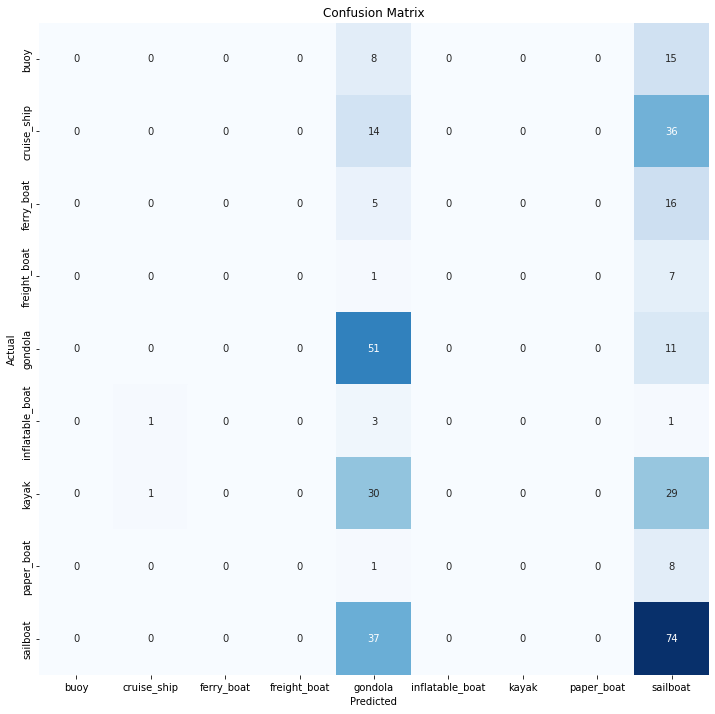

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        23
    cruise_ship       0.00      0.00      0.00        50
     ferry_boat       0.00      0.00      0.00        21
   freight_boat       0.00      0.00      0.00         8
        gondola       0.34      0.82      0.48        62
inflatable_boat       0.00      0.00      0.00         5
          kayak       0.00      0.00      0.00        60
     paper_boat       0.00      0.00      0.00         9
       sailboat       0.38      0.67      0.48       111

       accuracy                           0.36       349
      macro avg       0.08      0.17      0.11       349
   weighted avg       0.18      0.36      0.24       349



In [11]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)